# Job Change of Data Scientists | Data Science Project | Data Preprocessing

> Data from [Kaggle](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists) with modification in problem context.

*This project was completed as a part of Rakamin Academy Data Science Bootcamp.*

Ascencio, a leading Data Science agency, offers training courses to companies to enhance their employees' skills. Companies want to predict which employees are **unlikely to seek a job change** after completing the course, as well as identify those who are **likely to finish it quickly**. By focusing on employees who are committed to staying and can contribute sooner, Ascencio helps companies optimize their training investments.

To achieve this, Ascencio will build two machine learning models: one to predict the training hours needed for an employee to complete the course, and another to predict whether an employee will seek a job change or not.

# Prepare Everything!

In [823]:
# import library
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
%matplotlib inline
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('matplotlib version : ',mpl.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  2.2.1
pandas version :  2.2.3
matplotlib version :  3.10.0
seaborn version :  0.13.2


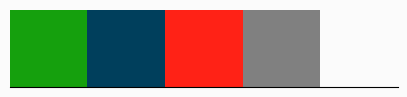

In [824]:
# color palette
green = '#15a00d'
blue = '#003f5c'
red = '#ff2216'
gray = 'gray'
bg_color = '#fbfbfb'
sns.palplot([green,blue,red,gray,bg_color])

In [825]:
# default setting
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.facecolor"] = bg_color
plt.rcParams["axes.facecolor"] = bg_color
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams['ytick.major.size'] = 0
plt.rcParams['ytick.minor.size'] = 0
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['axes.axisbelow'] = True

In [826]:
# read the data
df_train = pd.read_csv(r'Data/aug_train.csv')
df_test = pd.read_csv(r'Data/aug_test.csv')

# Data Preprocessing

## A. Feature Selection

Check that we will only use these columns as features<br/>
'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job'

In [827]:
# drop column enrollee_id, city, and training_hours
df_train.drop(['enrollee_id','city','training_hours'], axis=1, inplace=True)
df_train.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,0.0


In [828]:
# check columns
df_train.columns

Index(['city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job', 'target'],
      dtype='object')

## B. Feature Revision

We will rename, grouping, and imputation data based on 1_EDA.ipynb analysis. We will set copy to df dataframe from df_train dataframe.

In [829]:
# rename relevent_experience to relevant_experience
df_train.rename(columns={'relevent_experience':'relevant_experience'}, inplace=True)

# copy the data
df = df_train.copy()

# grouping city_development_index
df['city_development_index'] = df_train['city_development_index'].apply(lambda x: '<=0.6' if x <= 0.6
                                                                                else '0.6-0.7' if x <= 0.7
                                                                                else '0.7-0.8' if x <= 0.8
                                                                                else '0.8-0.9' if x <= 0.9
                                                                                else np.nan if pd.isna(x)
                                                                                else '0.9-1.0')

# grouping relevant_experience
df['relevant_experience'] = df_train['relevant_experience'].apply(lambda x: True if x == "Has relevent experience" 
                                                 else np.nan if pd.isna(x) else False)

# grouping enrolled_university
df['enrolled_university'] = df_train['enrolled_university'].apply(lambda x: "No Enroll" if x == "no_enrollment"
                                                                        else "Full Time" if x == "Full time course" 
                                                                        else np.nan if pd.isna(x) else "Part Time")

# grouping and imputation major_discipline
df['major_discipline'] = df_train['major_discipline'].apply(lambda x: "STEM" if x == "STEM"
                              else "No Major" if x == "No Major" 
                              else np.nan if pd.isna(x) else "Non-STEM")
df['major_discipline'] = np.where((df['education_level'].isin(['Graduate', 'Masters'])) & (df['major_discipline'] == 'No Major'), np.nan, 
                        np.where((df['education_level'].isin(['Primary School', 'High School'])) & (df['major_discipline'].isnull()),'No Major',df['major_discipline']))

# grouping experience
df['experience'] = df_train['experience'].apply(lambda x: "Early Career" if x in ['<1','1','2','3','4']
                                                        else "Mid Career" if x in ['5','6','7','8','9','10']
                                                        else "Senior Career" if x in ['11','12','13','14','15']
                                                        else np.nan if pd.isna(x) else "High Experience")

# grouping company_size
df['company_size'] = df_train['company_size'].apply(lambda x: "Medium" if x in ['100-500', '500-999']
                                                            else "Large" if x in ['1000-4999', '5000-9999']
                                                            else "Very Large" if x in ['10000+'] 
                                                            else np.nan if pd.isna(x) else "Small")

# rename company_type
df['company_type'] = df_train['company_type'].apply(lambda x: "Early Startup" if x == "Early Stage Startup" else x)

# check data
df.head(10)

,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
0,0.9-1.0,Male,True,No Enroll,Graduate,STEM,High Experience,NaN,NaN,1,1.0
1,0.7-0.8,Male,False,No Enroll,Graduate,STEM,Senior Career,Small,Pvt Ltd,>4,0.0
2,0.6-0.7,NaN,False,Full Time,Graduate,STEM,Mid Career,NaN,NaN,never,0.0
3,0.7-0.8,NaN,False,NaN,Graduate,Non-STEM,Early Career,NaN,Pvt Ltd,never,1.0
4,0.7-0.8,Male,True,No Enroll,Masters,STEM,High Experience,Small,Funded Startup,4,0.0
5,0.7-0.8,NaN,True,Part Time,Graduate,STEM,Senior Career,NaN,NaN,1,1.0
6,0.9-1.0,Male,True,No Enroll,High School,No Major,Mid Career,Small,Funded Startup,1,0.0
7,0.7-0.8,Male,True,No Enroll,Graduate,STEM,Senior Career,Small,Pvt Ltd,>4,1.0
8,0.9-1.0,Male,True,No Enroll,Graduate,STEM,Mid Career,Small,Pvt Ltd,1,1.0
9,0.9-1.0,NaN,True,No Enroll,Graduate,STEM,High Experience,Very Large,Pvt Ltd,>4,0.0


## C. Type Data

In [830]:
# check type data
print(df.info())
# relevant_experience have bool type since it only yes or no value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  19158 non-null  object 
 1   gender                  14650 non-null  object 
 2   relevant_experience     19158 non-null  bool   
 3   enrolled_university     18772 non-null  object 
 4   education_level         18698 non-null  object 
 5   major_discipline        18447 non-null  object 
 6   experience              19093 non-null  object 
 7   company_size            13220 non-null  object 
 8   company_type            13018 non-null  object 
 9   last_new_job            18735 non-null  object 
 10  target                  19158 non-null  float64
dtypes: bool(1), float64(1), object(9)
memory usage: 1.5+ MB
None


In [833]:
# change type to category
df['city_development_index'] = pd.Categorical(df['city_development_index'], categories=['<=0.6','0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0'], ordered=True)
df['gender'] = pd.Categorical(df['gender'], categories=["Male","Female","Other"])
df['relevant_experience'] = pd.Categorical(df['relevant_experience'], categories=[False, True], ordered=True)
df['enrolled_university'] = pd.Categorical(df['enrolled_university'], categories=['No Enroll','Part Time','Full Time'], ordered=True)
df['education_level'] = pd.Categorical(df['education_level'], categories=['Primary School','High School','Graduate','Masters','Phd'], ordered=True)
df['major_discipline'] = pd.Categorical(df['major_discipline'], categories=['No Major','Non-STEM','STEM'])
df['experience'] = pd.Categorical(df['experience'], categories=['Early Career','Mid Career','Senior Career','High Experience'], ordered=True)
df['company_size'] = pd.Categorical(df['company_size'], categories=['Small','Medium','Large','Very Large'], ordered=True)
df['company_type'] = pd.Categorical(df['company_type'], categories=['Early Startup','Funded Startup','NGO','Public Sector','Pvt Ltd','Other'])
df['last_new_job'] = pd.Categorical(df['last_new_job'], categories=['never','1','2','3','4','>4'], ordered=True)
df['target'] = pd.Categorical(df['target'], categories=[0,1], ordered=True)


In [835]:
# check data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   city_development_index  19158 non-null  category
 1   gender                  14650 non-null  category
 2   relevant_experience     19158 non-null  category
 3   enrolled_university     18772 non-null  category
 4   education_level         18698 non-null  category
 5   major_discipline        18447 non-null  category
 6   experience              19093 non-null  category
 7   company_size            13220 non-null  category
 8   company_type            13018 non-null  category
 9   last_new_job            18735 non-null  category
 10  target                  19158 non-null  category
dtypes: category(11)
memory usage: 207.8 KB
None


## D. Handle Missing Value

We will using LGBMClasifier (ML model) to imputate missing data since missing value is only on categorical feature

In [836]:
# handling missing value using LGBM Classifier
for col in [x for x in df.columns if df[x].isnull().sum() > 0]:
    data = df.copy()
    nan_ixs = np.where(data[col].isnull())[0]
    data['is_nan'] = 0
    data.loc[nan_ixs, 'is_nan'] = 1

    X = data.drop([col], axis=1)
    y = data[col]
    for col2 in X.columns:
        X[col2] = pd.factorize(X[col2], sort=True)[0]
    data = X.join(y)

    train = data[data['is_nan'] == 0]
    test = data[data['is_nan'] == 1]
    X_train = train.drop([col, 'is_nan'], axis=1)
    y_train = train[col]
    X_test = test.drop([col, 'is_nan'], axis=1)

    model = LGBMClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    df.loc[nan_ixs, col] = y_pred

df.head(10)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 14650, number of used features: 10
[LightGBM] [Info] Start training from score -2.470943
[LightGBM] [Info] Start training from score -0.102634
[LightGBM] [Info] Start training from score -4.339922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 18772, number of used features: 10
[LightGBM] [Info] Start training from score -1.608746
[LightGBM] [Info] Start training from score -0.306467
[LightGBM] [Info] Start trai

,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
0,0.9-1.0,Male,True,No Enroll,Graduate,STEM,High Experience,Small,Pvt Ltd,1,1
1,0.7-0.8,Male,False,No Enroll,Graduate,STEM,Senior Career,Small,Pvt Ltd,>4,0
2,0.6-0.7,Male,False,Full Time,Graduate,STEM,Mid Career,Small,Pvt Ltd,never,0
3,0.7-0.8,Male,False,No Enroll,Graduate,Non-STEM,Early Career,Small,Pvt Ltd,never,1
4,0.7-0.8,Male,True,No Enroll,Masters,STEM,High Experience,Small,Funded Startup,4,0
5,0.7-0.8,Male,True,Part Time,Graduate,STEM,Senior Career,Small,Pvt Ltd,1,1
6,0.9-1.0,Male,True,No Enroll,High School,No Major,Mid Career,Small,Funded Startup,1,0
7,0.7-0.8,Male,True,No Enroll,Graduate,STEM,Senior Career,Small,Pvt Ltd,>4,1
8,0.9-1.0,Male,True,No Enroll,Graduate,STEM,Mid Career,Small,Pvt Ltd,1,1
9,0.9-1.0,Male,True,No Enroll,Graduate,STEM,High Experience,Very Large,Pvt Ltd,>4,0


## E. Feature Encoding

We will use Label Endoding for city_development_index, relevent_experience, enrolled_university, education_level, experience, company_size, and last_new_job (6 features)

In [837]:
# define columns for label encoding
le_cols = ['city_development_index', 'relevant_experience','enrolled_university', 
           'education_level', 'experience', 'company_size', 'last_new_job']

# label encoding using pd.factorize with sort=True
for col in le_cols:
    df[col] = pd.factorize(df[col], sort=True)[0]

# check data
df.head(10)

,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
0,4,Male,1,0,2,STEM,3,0,Pvt Ltd,1,1
1,2,Male,0,0,2,STEM,2,0,Pvt Ltd,5,0
2,1,Male,0,2,2,STEM,1,0,Pvt Ltd,0,0
3,2,Male,0,0,2,Non-STEM,0,0,Pvt Ltd,0,1
4,2,Male,1,0,3,STEM,3,0,Funded Startup,4,0
5,2,Male,1,1,2,STEM,2,0,Pvt Ltd,1,1
6,4,Male,1,0,1,No Major,1,0,Funded Startup,1,0
7,2,Male,1,0,2,STEM,2,0,Pvt Ltd,5,1
8,4,Male,1,0,2,STEM,1,0,Pvt Ltd,1,1
9,4,Male,1,0,2,STEM,3,3,Pvt Ltd,5,0


We will use One-Hot Encoding for gender (2 features), major_discipline (2 features), and company_type (5 features). We just using n-1 unique value of each feature to avoid multicollinearity.

In [838]:
# one hot encoding 
df = pd.get_dummies(df,columns=['gender','major_discipline','company_type'],dtype=int)

# drop one column of each one hot encoded to avoid multicollinearity
df.drop(['gender_Other','major_discipline_No Major','company_type_Other'], axis=1, inplace=True)

# rearrange so target column is the last column
df = pd.concat([df.drop('target', axis=1), df['target']], axis=1)

# check data
df.head(10)

,city_development_index,relevant_experience,enrolled_university,education_level,experience,company_size,last_new_job,gender_Male,gender_Female,major_discipline_Non-STEM,major_discipline_STEM,company_type_Early Startup,company_type_Funded Startup,company_type_NGO,company_type_Public Sector,company_type_Pvt Ltd,target
0,4,1,0,2,3,0,1,1,0,0,1,0,0,0,0,1,1
1,2,0,0,2,2,0,5,1,0,0,1,0,0,0,0,1,0
2,1,0,2,2,1,0,0,1,0,0,1,0,0,0,0,1,0
3,2,0,0,2,0,0,0,1,0,1,0,0,0,0,0,1,1
4,2,1,0,3,3,0,4,1,0,0,1,0,1,0,0,0,0
5,2,1,1,2,2,0,1,1,0,0,1,0,0,0,0,1,1
6,4,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0
7,2,1,0,2,2,0,5,1,0,0,1,0,0,0,0,1,1
8,4,1,0,2,1,0,1,1,0,0,1,0,0,0,0,1,1
9,4,1,0,2,3,3,5,1,0,0,1,0,0,0,0,1,0
